In [1]:
import pandas as pd
from scipy.spatial.distance import pdist, jaccard
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import numpy as np
from seaborn import heatmap
%matplotlib inline

In [7]:
df = pd.read_csv('Allan.csv',delimiter=",")

In [8]:
np.unique(df.iloc[:,1].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [9]:
import numpy as np
array = np.array([],dtype='uint8')

In [60]:
??pdist

In [18]:
def generate_ocurrence_matrix(df):
    """
    Generate occurrence matrix from dataframe
    
    Parameters
    ----------
    df : dataframe
         A dataframe where the first column contains the names of the samples and the second
         contains the molecular weights
    
    Returns
    ----------
    matrix : narray
             The occurrence matrix associated with the dataframe
    names  : list
             The list of names of the samples
    """
    
    # We first extract the min and max mw
    min_mw = df.iloc[:,1].min()
    max_mw = df.iloc[:,1].max()
    
    # We group the mws of each sample
    grouped = df.groupby('Sample')
    
    # Now, we build the occurrence matrix
    names = [x for x,y in grouped]
    matrix = []
    
    for _, group in grouped:
        
        mwsSample = group.iloc[:,1].values
        rowSample = [(i in mwsSample) for i in range(min_mw,max_mw+1)]
        
        matrix.append(mwsSample)
        
    
    return np.array(matrix), names   

In [19]:
matrix,names = generate_ocurrence_matrix(df)

In [20]:
matrix[0]

array([ 4,  9, 15, 20, 28, 38, 44])

In [21]:
matrix[1]

array([ 3, 10, 16, 20, 28, 38, 46])

In [55]:
compute_distance(matrix[0],matrix[2],2,'jaccard')

0.125

In [39]:
def compute_metric(tp,fp,fn,metric):
    if(metric=='jaccard'):
        return (fp+fn)/(tp+fp+fn)
    if(metric=='dice'):
        return (fp+fn)/(2*tp+fp+fn)

In [51]:
def compute_distance(vector1,vector2,tolerance,metric):
    tp = 0
    fp = 0
    fn = 0
    fps = []
    v1Copy = vector1.tolist().copy()
    v2Copy = vector2.tolist().copy()
    takenindices = []
    for i in range(0,len(v1Copy)):
        v1 = v1Copy[i]
        found = False
        for j in range(0,len(v2Copy)):
            if j not in takenindices:
                v2 = v2Copy[j]
                if(v1>= v2-tolerance and v1 <= v2+tolerance and not(found)):
                    tp += 1
                    found = True
                    takenindices.append(j)
        if not(found):
            fps.append(v1)
            

    fp = len(fps)
    fn = len(v2Copy)-len(takenindices)
    
    return compute_metric(tp,fp,fn,metric)

In [145]:
def generate_similarity_matrix(df,tolerance,metric):
    # We group the mws of each sample
    grouped = df.groupby('Sample')
    names = [x for x,y in grouped]
    
    matrix  = np.zeros((len(names),len(names)),dtype='float32')
    for i in range(0,len(names)):
        for j in range(i+1,len(names)):
            matrix[i][j] = compute_distance(grouped.agg(list).iloc[i,0],
                                            grouped.agg(list).iloc[j,0],
                                            tolerance,
                                            metric)
            matrix[j][i] = matrix[i][j]
    return matrix, names

In [146]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [147]:
def generate_dendogram(df,tolerance=0,linkage='average',metric='jaccard',threshold=0.35,name='dendogram.jpg'):
    """
    Generate occurrence matrix from dataframe
    
    Parameters
    ----------
    df : dataframe
        A dataframe where the first column contains the names of the samples and the second
        contains the molecular weights
    tolerance: int >= 0
        A value for considering that two bands are matched.
    linkage: string
        The linkage method for building the dendogram:
        ‘ward’, ‘complete’, ‘average’, ‘single’.
    metric: string
        One of the following metrics to compute the distance matrix:
        'jaccard' or 'dice'
    threshold: float >=0 and <=1
        Value that is considered to create a cluster. 
    name: string
        Path where the dendogram will be saved
    Returns
    ----------
    This methods shows the associated dendogram and saves the image.
    """

    if(metric=='jaccard' or metric=='dice'):            
        m,names = generate_similarity_matrix(df,tolerance,metric)
    else:
        raise Excepction('Only jaccard and dice are supported')
    
    clustering = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage=linkage,
                                      distance_threshold=threshold)
    clustering.fit(m)
    
    plot_dendrogram(clustering,leaf_font_size=10.,orientation='left',labels = names)
    plt.savefig(name)
    

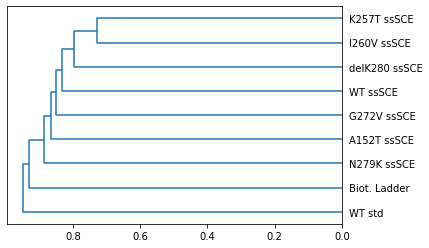

In [151]:
generate_dendogram(df,tolerance=0)

In [154]:
def generate_heatmap(df,tolerance=0,metric='jaccard',name='heatmap.jpg'):
    m,names = generate_similarity_matrix(df,tolerance,metric)
    heatmap(m,xticklabels=names,yticklabels=names)
    plt.savefig(name)

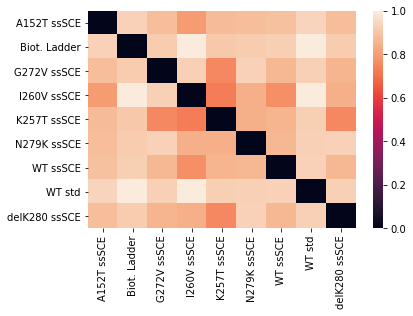

In [155]:
generate_heatmap(df)